In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (10, 8)

# Implicit Methods for Systems of ODEs

## Linear system

Consider the linear system of ODEs

$$\frac{dX_A}{dt} = -\alpha X_A + \beta X_B$$ 

$$\frac{dX_B}{dt} = \alpha X_A - \beta X_B$$

(system from F. Timmes summer school notes).  We will take:

$$X_A + X_B = 1$$



In matrix form, we can write this as:

$$\frac{d}{dt} \left ( \begin{array}{c}
                                 X_A \\ X_B 
                                \end{array} \right ) 
    = \left ( \begin{array}{rr} 
                           -\alpha & \beta \\
                            \alpha  & -\beta 
                 \end{array}   \right )
 \left ( \begin{array}{c}
                                 X_A \\ X_B 
                                \end{array} \right )$$
                                
or

$$\dot{\bf Y} = {\bf A}{\bf Y}$$ 

with ${\bf Y} = (X_A \,\, X_B)^\intercal$.

This has the solution (for $X_B(0) = 0$):

$$\frac{X_B}{X_A} = \frac{e^{(\alpha + \beta)t} - 1}
    {\tfrac{\beta}{\alpha} e^{(\alpha + \beta)t } + 1}$$
    
and the long-time behavior:

$$X_B/X_A \rightarrow \alpha/\beta$$.

The characteristic timescale for change is $\tau = 1/(\alpha + \beta)$, and we see that

$$d(X_A + X_B)/dt = 0$$
    

### Discretization

The backward-Euler discretization of this system is:

$${\bf Y}^{n+1} = {\bf Y}^{n} + \tau {\bf A} {\bf Y}^{n+1}$$

We can write this as a linear system:

$$({\bf I} - \tau {\bf A}) {\bf Y}^{n+1} = {\bf Y}^n$$

This is in the traditional "${\bf A}{\bf x} = {\bf b}$" form of a linear system.


First we need the righthand side function:

In [5]:
alpha = 1.e9
beta = 1.e-5

def ode_mat():
    """ return the matrix A in the linear system of ODEs """
    return np.array([[-alpha,  beta],
                     [+alpha, -beta]], dtype=np.float64)

def rhs(t, Y):
    """ RHS of the system for explicit methods """
    return np.array([-alpha*Y[0] + beta*Y[1],
                     +alpha*Y[0] - beta*Y[1]])

In [9]:
def integrate(Y_0, dt, tmax):
    """ perform a backward-Euler integration """

    XA = Y_0[0]
    XB = Y_0[1]

    tout = [0.0]
    xaout = [XA]
    xbout = [XB]

    t = 0.0
    while t < tmax:

        # create the matrix
        J = np.eye(2) - dt*ode_mat()

        b = np.array([XA, XB])

        # solve the linear system J x = b
        x = np.linalg.solve(J, b)

        XA = x[0]
        XB = x[1]

        t += dt

        tout.append(t)
        xaout.append(XA)
        xbout.append(XB)

    return np.asarray(tout), np.asarray(xaout), np.asarray(xbout)

In [24]:
def analytic(t):
    return (np.exp((alpha+beta)*t) - 1.0) / ((beta/alpha)*np.exp((alpha+beta)*t) + 1.0)

In [32]:
def plot(t, XA, XB, label=None):
    frac_equil = alpha / beta
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    tfine = np.linspace(0, t.max(), 1000)
    
    ax.plot(tfine, analytic(tfine) / frac_equil, label="analytic")
    ax.plot(t, (XB/XA) / frac_equil, label=label)
    
    ax.set_xlabel("t")
    ax.set_ylabel(r"$(X_B/X_A) / (\alpha/\beta)$")
    
    ax.legend(frameon=False)
    return fig

In [33]:
tref = 1.0/(alpha + beta)

In [42]:
t, XA, XB = integrate([1.0, 0.0], 0.5*tref, 100*tref)

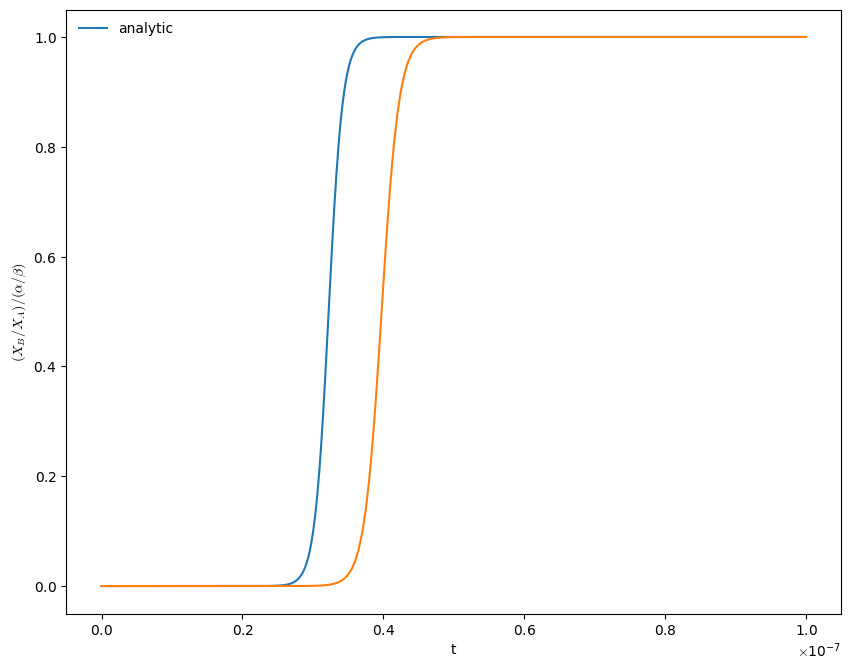

In [43]:
fig = plot(t, XA, XB)

In [36]:
def rk4_integrate(Y_0, dt, tmax):
    """ 4th-order explicit Runge-Kutta for comparison """

    XA = Y_0[0]
    XB = Y_0[1]

    tout = [0.0]
    xaout = [XA]
    xbout = [XB]

    t = 0.0
    while t < tmax:

        k1 = rhs(t, np.array([XA, XB]))
        k2 = rhs(t+0.5*dt, np.array([XA+0.5*dt*k1[0], XB+0.5*dt*k1[1]]))
        k3 = rhs(t+0.5*dt, np.array([XA+0.5*dt*k2[0], XB+0.5*dt*k2[1]]))
        k4 = rhs(t+dt, np.array([XA+dt*k3[0], XB+dt*k3[1]]))

        XA += (dt/6.0)*(k1[0] + 2.0*k2[0] + 2.0*k3[0] + k4[0])
        XB += (dt/6.0)*(k1[1] + 2.0*k2[1] + 2.0*k3[1] + k4[1])

        t += dt

        tout.append(t)
        xaout.append(XA)
        xbout.append(XB)

    return np.asarray(tout), np.asarray(xaout), np.asarray(xbout)

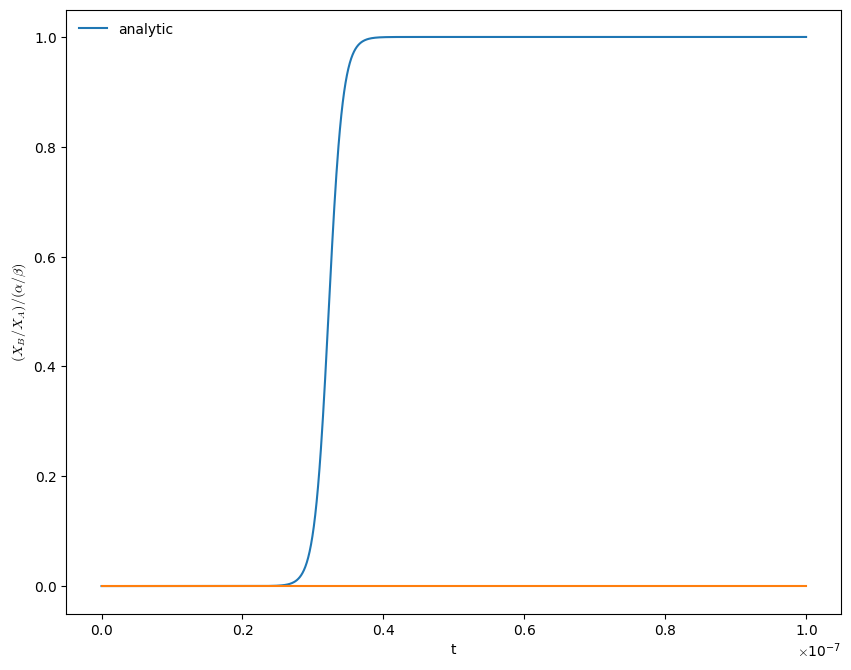

In [39]:
t, XA, XB = rk4_integrate([1.0, 0.0], 5.0*tref, 100*tref)
fig = plot(t, XA, XB)

Just to be fair to RK4, let's use the implementation in scipy, which can adapt the timestep as needed.  Let's see how many steps it can solve this in.

In [44]:
from scipy.integrate import solve_ivp

In [82]:
sol = solve_ivp(rhs, [0, 100*tref], [1.0, 0.0],
                method="RK45", dense_output=True,
                rtol=1.e-4, atol=1.e-17)

In [83]:
print(sol)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 548
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f14ea656340>
   status: 0
  success: True
        t: array([0.00000000e+00, 1.00000000e-22, 1.10000000e-21, 1.11000000e-20,
       1.11100000e-19, 1.11110000e-18, 1.11111000e-17, 1.11111100e-16,
       1.11111110e-15, 1.11111111e-14, 1.11111111e-13, 1.11111111e-12,
       1.11111111e-11, 1.11111111e-10, 5.13094363e-10, 1.02783760e-09,
       1.60109918e-09, 2.19768815e-09, 2.80121521e-09, 3.40662809e-09,
       4.01255936e-09, 4.61863718e-09, 5.22475731e-09, 5.83088981e-09,
       6.43702596e-09, 7.04316319e-09, 7.64930074e-09, 8.25543839e-09,
       8.86157606e-09, 9.46771375e-09, 1.00738514e-08, 1.06799891e-08,
       1.12861268e-08, 1.18922645e-08, 1.24984022e-08, 1.31045399e-08,
       1.37106776e-08, 1.43168153e-08, 1.49229529e-08, 1.55290907e-08,
       1.61352284e-08, 1.67413661e-08, 1.73475040

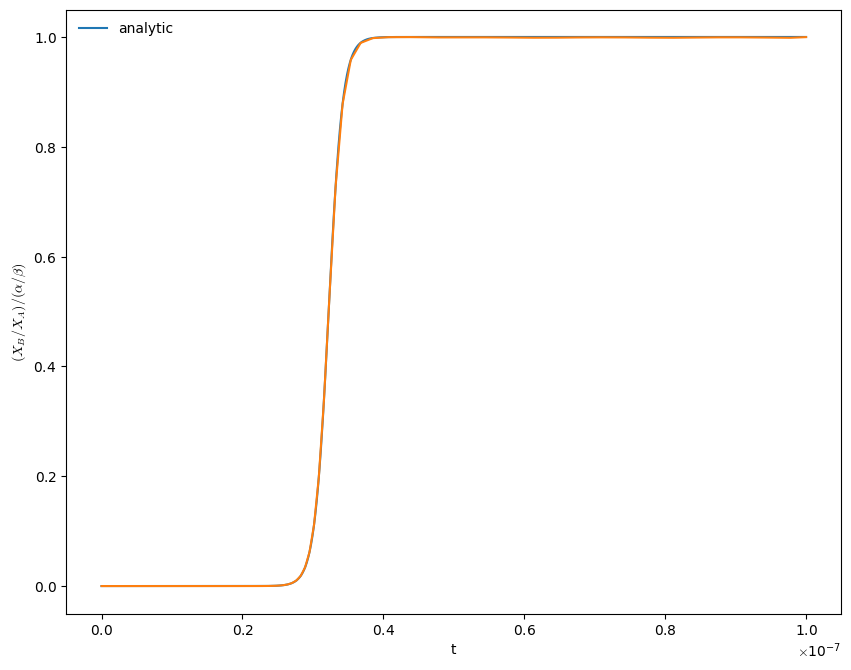

In [84]:
fig = plot(sol.t, sol.y[0,:], sol.y[1,:])

In [85]:
sol.y.shape

(2, 91)

Notice that it basically needed to step at the characteristic timescale to get a reasonable solution.

Byrne & Hindmarsh (1986) give a pragmatic definition of a stiff system:

  > Perhaps the most pragmatic way to determine the stiffness of a system of ODEs
  > is simply to solve it with a non-stiff differential equation package … 
  > Then, record the cost of solving the problem.  By the way, it would be prudent to
  > impose a limit on CPU time or the number of function evaluations.  Similarly, solve 
  > the problem with a stiff ODE package …  Upper bounds on the cost should again be imposed.
  > Now compare the costs of the two solutions over the same time interval.  If the stiff
  > ODE solver was substantially less expensive to use than the non-stiff solver, then
  > the problem was stiff.